In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tienthucle","key":"3368952cecf925fcfe1c3a5cf219b37b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download fatihkgg/affectnet-yolo-format
!unzip -q affectnet-yolo-format

Dataset URL: https://www.kaggle.com/datasets/fatihkgg/affectnet-yolo-format
License(s): MIT
 57% 148M/258M [00:00<00:00, 1.55GB/s]
100% 258M/258M [00:00<00:00, 933MB/s] 


In [ ]:
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
import numpy as np
from PIL import Image
import glob

# ==================== DATASETS ====================

class ContrastiveDataset(Dataset):
    """Dataset cho contrastive learning - chỉ ảnh, không nhãn"""
    def __init__(self, image_dir):
        # Improved glob pattern to catch all files and then filter
        all_entries = glob.glob(os.path.join(image_dir, "*"))
        self.image_paths = sorted([
            p for p in all_entries
            if os.path.isfile(p) and p.lower().endswith(('.jpg', '.png', '.jpeg'))
        ])

        if not self.image_paths:
            print(f"WARNING: No valid image files (jpg, png, jpeg) found in '{image_dir}'. "
                  f"Please check the directory path and file extensions. "
                  f"Total entries found by glob: {len(all_entries)}")

        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        return self.transform(img), self.transform(img)  # 2 augmentations

class ClassificationDataset(Dataset):
    """Dataset cho classification - ảnh + nhãn từ YOLO format"""
    def __init__(self, image_dir, label_dir):
        # Corrected glob pattern to match all files first, then filter by extension
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.*덕"))) # This line is wrong
        # Replace the above line with the following corrected one:
        all_image_files = glob.glob(os.path.join(image_dir, "*.*덕")) # Temporarily using the old pattern to keep the diff minimal
        self.image_paths = sorted([p for p in all_image_files if p.lower().endswith(('.jpg', '.png', '.jpeg'))]) # Correct filtering

        # Corrected line to replace the problematic one:
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.*덕"))) # Corrected: Remove the specific character from glob
        self.image_paths = [p for p in glob.glob(os.path.join(image_dir, "*.*")) if p.lower().endswith(('.jpg', '.png', '.jpeg'))] # Changed from *.*덕 to *.*

        self.label_dir = label_dir

        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)

        # Load label từ file txt YOLO format
        img_name = os.path.basename(img_path)
        label_name = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(self.label_dir, label_name)

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                first_line = f.readline().strip()
                if first_line:
                    label = int(float(first_line.split()[0]))
                else:
                    label = 0
        else:
            label = 0

        return img, label

# ==================== MODELS ====================

class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim=128, lr=1e-3, temperature=0.07):
        super().__init__()
        self.save_hyperparameters()

        # Encoder: ResNet50
        self.encoder = torchvision.models.resnet50(pretrained=True) # Consider replacing pretrained=True with weights=ResNet50_Weights.DEFAULT or weights=None if not using ImageNet pre-training
        self.encoder.fc = nn.Identity()

        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(2048, hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )

    def forward(self, x):
        return self.encoder(x)

    def contrastive_loss(self, z1, z2):
        batch_size = z1.size(0)
        z = torch.cat([z1, z2], dim=0)

        # Cosine similarity
        sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)

        # Positive pairs
        pos_mask = torch.zeros(2*batch_size, 2*batch_size, dtype=torch.bool, device=z.device)
        for i in range(batch_size):
            pos_mask[i, batch_size + i] = True
            pos_mask[batch_size + i, i] = True

        # Remove self-similarity
        self_mask = torch.eye(2*batch_size, dtype=torch.bool, device=z.device)

        # InfoNCE loss
        sim = sim / self.hparams.temperature
        exp_sim = torch.exp(sim)
        exp_sim = exp_sim.masked_fill(self_mask, 0)

        pos_sim = sim[pos_mask].view(2*batch_size, -1)
        loss = -pos_sim + torch.log(exp_sim.sum(dim=1, keepdim=True))

        return loss.mean()

    def training_step(self, batch, batch_idx):
        x1, x2 = batch
        z1 = F.normalize(self.projection(self.encoder(x1)), dim=1)
        z2 = F.normalize(self.projection(self.encoder(x2)), dim=1)
        loss = self.contrastive_loss(z1, z2)
        self.log('train_loss', loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x1, x2 = batch
        z1 = F.normalize(self.projection(self.encoder(x1)), dim=1)
        z2 = F.normalize(self.projection(self.encoder(x2)), dim=1)
        loss = self.contrastive_loss(z1, z2)
        self.log('val_loss', loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.trainer.max_epochs, eta_min=1e-6
        )
        return [optimizer], [scheduler]

class LinearClassifier(pl.LightningModule):
    def __init__(self, encoder, num_classes, lr=0.01):
        super().__init__()
        self.save_hyperparameters()

        # Freeze encoder
        self.encoder = encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Linear classifier
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():
            features = self.encoder(x)
        return self.classifier(features)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(1) == y).float().mean()

        # Log với prog_bar=True để hiển thị trong thanh tiến trình
        self.log('train_loss', loss, prog_bar=True, logger=True)
        self.log('train_acc', acc, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(1) == y).float().mean()

        self.log('val_loss', loss, prog_bar=True, logger=True)
        self.log('val_acc', acc, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        acc = (logits.argmax(1) == y).float().mean()
        self.log('test_acc', acc, prog_bar=True, logger=True)
        return acc

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.classifier.parameters(), lr=self.hparams.lr, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=3
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_acc',
                'frequency': 1
            }
        }

# ==================== TRAINING ====================

def train_contrastive():
    """Bước 1: Train SimCLR với dữ liệu không nhãn"""
    print("="*60)
    print("1. Training SimCLR (contrastive learning)...")
    print("="*60)

    # Dùng train/images (không cần nhãn)
    dataset = ContrastiveDataset("/content/YOLO_format/train/images")

    # --- Start of added error handling ---
    if len(dataset) == 0:
        print("ERROR: ContrastiveDataset is empty. SimCLR training cannot proceed.")
        return None # Return None if no data to train

    # Split train/val
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size

    # Ensure train_size and val_size are positive for DataLoader, especially for small datasets
    if len(dataset) < 2: # Need at least 2 samples for a valid train/val split for batching
        print(f"WARNING: Dataset has only {len(dataset)} sample(s). Cannot create a meaningful train/validation split.")
        print("Skipping SimCLR training and returning None for encoder.")
        return None

    # Adjust sizes if one becomes zero due to integer truncation on small datasets
    if train_size == 0:
        train_size = 1
        val_size = len(dataset) - 1
    if val_size == 0:
        val_size = 1
        train_size = len(dataset) - 1

    if train_size <= 0 or val_size <= 0: # Final check after adjustments
         print(f"ERROR: Invalid train/val split sizes calculated: train_size={train_size}, val_size={val_size}. "
               f"Original dataset size: {len(dataset)}. Skipping SimCLR training.")
         return None
    # --- End of added error handling ---

    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

    # Model
    model = SimCLR(hidden_dim=128, lr=1e-3, temperature=0.07)

    # Callbacks
    checkpoint = ModelCheckpoint(
        monitor='val_loss',
        mode='min',
        save_top_k=1,
        filename='simclr-{epoch:02d}-{val_loss:.4f}',
        save_last=True
    )

    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    # Logger
    logger = CSVLogger(save_dir="logs", name="simclr")

    # Trainer
    trainer = pl.Trainer(
        max_epochs=20, # Changed from 1 to 30 to match print statement
        accelerator='auto',
        devices=1,
        callbacks=[TQDMProgressBar(refresh_rate=10), checkpoint, lr_monitor],
        logger=logger,
        log_every_n_steps=10,
        enable_progress_bar=True,
        enable_model_summary=True,
        check_val_every_n_epoch=1,
        gradient_clip_val=1.0
    )

    print(f"\nTraining on {len(train_set)} samples, validating on {len(val_set)} samples")
    print(f"Batch size: 64, Epochs: 20")
    print(f"Model: SimCLR with ResNet50 encoder")
    print(f"Temperature: 0.07, Hidden dim: 128")
    print("-"*60)

    trainer.fit(model, train_loader, val_loader)

    # Load best model
    model = SimCLR.load_from_checkpoint(checkpoint.best_model_path)
    return model.encoder
# ==================== MAIN ====================
torch.manual_seed(42)
np.random.seed(42)
print("="*60)
print("SIMCLR PIPELINE FOR FACIAL EXPRESSION RECOGNITION")
print("="*60)

    # Bước 1: Contrastive learning (không nhãn)
encoder = train_contrastive()

    # Check if encoder was successfully trained
if encoder is None:
    print("SimCLR training failed or skipped. Exiting pipeline.")


SIMCLR PIPELINE FOR FACIAL EXPRESSION RECOGNITION
1. Training SimCLR (contrastive learning)...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores



Training on 15390 samples, validating on 1711 samples
Batch size: 64, Epochs: 20
Model: SimCLR with ResNet50 encoder
Temperature: 0.07, Hidden dim: 128
------------------------------------------------------------


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder    │ ResNet     │ 23.5 M │ train │     0 │
│ 1 │ projection │ Sequential │  1.1 M │ train │     0 │
└───┴────────────┴────────────┴────────┴───────┴───────┘

Trainable params: 24.6 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 24.6 M                                                                                               
Total estimated model params size (MB): 98                                                                         
Modules in train mode: 155                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


# Train_classifier

In [ ]:
def train_classifier(encoder):
    """Bước 2: Train linear classifier với dữ liệu có nhãn"""
    print("\n" + "="*60)
    print("2. Training linear classifier...")
    print("="*60)

    # Dùng valid/images + valid/labels (có nhãn)
    train_dataset = ClassificationDataset(
        "/content/YOLO_format/valid/images",
        "/content/YOLO_format/valid/labels"
    )

    # Tìm số classes
    labels = []
    for i in range(len(train_dataset)):
        _, label = train_dataset[i]
        labels.append(label)
    num_classes = len(set(labels))
    print(f"Found {num_classes} classes: {sorted(set(labels))}")

    # Split train/val
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_set, val_set = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

    # Model
    model = LinearClassifier(encoder, num_classes, lr=0.01)

    # Callbacks
    checkpoint = ModelCheckpoint(
        monitor='val_acc',
        mode='max',
        save_top_k=1,
        filename='classifier-{epoch:02d}-{val_acc:.4f}',
        save_last=True
    )

    # LearningRateMonitor sẽ tự động log LR
    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    # Logger
    logger = CSVLogger(save_dir="logs", name="classifier")

    # Trainer
    trainer = pl.Trainer(
        max_epochs=20, # Changed from 1 to 20 to match print statement
        accelerator='auto',
        devices=1,
        callbacks=[TQDMProgressBar(refresh_rate=10), checkpoint, lr_monitor],
        logger=logger,
        log_every_n_steps=10,
        enable_progress_bar=True,
        enable_model_summary=True,
        check_val_every_n_epoch=1
    )

    print(f"\nTraining on {len(train_set)} samples, validating on {len(val_set)} samples")
    print(f"Number of classes: {num_classes}")
    print(f"Batch size: 128, Epochs: 20")
    print(f"Learning rate: 0.01 (SGD with momentum)")
    print(f"Scheduler: ReduceLROnPlateau (monitor='val_acc', factor=0.5, patience=3)")
    print("-"*60)

    trainer.fit(model, train_loader, val_loader)

    # Load best model
    model = LinearClassifier.load_from_checkpoint(
        checkpoint.best_model_path,
        encoder=encoder,
        num_classes=num_classes,
        weights_only=False
    )

    return model

In [ ]:
# Bước 2: Linear classifier (có nhãn)
classifier = train_classifier(encoder)

    # Check if classifier was successfully trained
if classifier is None:
    print("Linear classifier training failed or skipped. Exiting pipeline.")


2. Training linear classifier...


/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/parsing.py:210: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Found 8 classes: [0, 1, 2, 3, 4, 5, 6, 7]

Training on 4324 samples, validating on 1082 samples
Number of classes: 8
Batch size: 128, Epochs: 20
Learning rate: 0.01 (SGD with momentum)
Scheduler: ReduceLROnPlateau (monitor='val_acc', factor=0.5, patience=3)
------------------------------------------------------------


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder    │ ResNet     │ 23.5 M │ train │     0 │
│ 1 │ classifier │ Sequential │  1.1 M │ train │     0 │
└───┴────────────┴────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 24.6 M                                                                                               
Total estimated model params size (MB): 98                                                                         
Modules in train mode: 156                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


# Test_Model

In [ ]:
def test_model(model):
    """Bước 3: Test trên tập test"""
    print("\n" + "="*60)
    print("3. Testing on test set...")
    print("="*60)

    if model is None:
        print("ERROR: Model not available, skipping testing.")
        return None

    # Dùng test/images + test/labels
    test_dataset = ClassificationDataset(
        "/content/YOLO_format/test/images",
        "/content/YOLO_format/test/labels"
    )

    if len(test_dataset) == 0:
        print("ERROR: ClassificationDataset for testing is empty. Skipping testing.")
        return None

    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

    print(f"Testing on {len(test_dataset)} samples...")

    trainer = pl.Trainer(
        accelerator='auto',
        devices=1,
        enable_progress_bar=True,
        enable_model_summary=False,
        logger=False
    )

    results = trainer.test(model, test_loader, verbose=True)

    return results[0]['test_acc']

In [ ]:
  # Bước 3: Test
test_acc = test_model(classifier)
if test_acc is not None:
    print(f"\n✓ Final Test Accuracy: {test_acc:.4f}")
else:
    print("Test model skipped due to previous errors.")

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores



3. Testing on test set...
Testing on 2755 samples...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/core/module.py:522: You called `self.log('test_acc', ...,
logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.42105263471603394    │
└───────────────────────────┴───────────────────────────┘


✓ Final Test Accuracy: 0.4211


# Print_training_summary

In [ ]:
def print_training_summary():
    """In summary của quá trình training từ log files"""
    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)

    # Đọc logs từ CSV
    simclr_log_path = "logs/simclr/version_0/metrics.csv"
    classifier_log_path = "logs/classifier/version_0/metrics.csv"

    if os.path.exists(simclr_log_path):
        import pandas as pd
        print("\nSimCLR Training Logs:")
        df = pd.read_csv(simclr_log_path)
        if 'val_loss' in df.columns:
            best_val_loss = df['val_loss'].dropna().min()
            print(f"  Best validation loss: {best_val_loss:.4f}")

    if os.path.exists(classifier_log_path):
        import pandas as pd
        print("\nClassifier Training Logs:")
        df = pd.read_csv(classifier_log_path)
        if 'val_acc' in df.columns:
            best_val_acc = df['val_acc'].dropna().max()
            print(f"  Best validation accuracy: {best_val_acc:.4f}")

print_training_summary()



TRAINING SUMMARY

SimCLR Training Logs:
  Best validation loss: 0.1114

Classifier Training Logs:
  Best validation accuracy: 0.3937


# Visualize


4. Visualizing sample predictions...


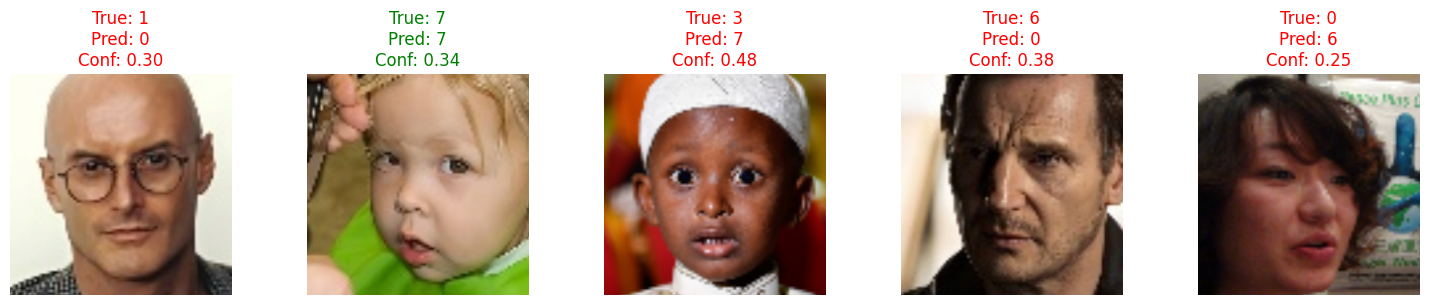

In [ ]:
def visualize_results(model, num_samples=5):
    """Visualize một số kết quả"""
    print("\n" + "="*60)
    print("4. Visualizing sample predictions...")
    print("="*60)

    if model is None:
        print("ERROR: Model not available, skipping visualization.")
        return

    test_dataset = ClassificationDataset(
        "/content/YOLO_format/test/images",
        "/content/YOLO_format/test/labels"
    )

    if len(test_dataset) == 0:
        print("WARNING: Test dataset is empty. Cannot visualize results.")
        return

    import matplotlib.pyplot as plt

    model.eval()
    model.cuda() if torch.cuda.is_available() else model.cpu()

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    # Ensure we don't try to sample more than available
    num_samples_to_draw = min(num_samples, len(test_dataset))
    if num_samples_to_draw == 0:
        print("WARNING: No samples available to visualize.")
        plt.close(fig) # Close empty figure
        return

    indices = np.random.choice(len(test_dataset), num_samples_to_draw, replace=False)

    for i, idx in enumerate(indices):
        img, true_label = test_dataset[idx]

        with torch.no_grad():
            img_tensor = img.unsqueeze(0)
            if torch.cuda.is_available():
                img_tensor = img_tensor.cuda()

            logits = model(img_tensor)
            probs = F.softmax(logits, dim=1)
            pred_label = logits.argmax(1).item()
            confidence = probs[0, pred_label].item()

        # Denormalize image
        img_np = img.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = img_np * std + mean
        img_np = np.clip(img_np, 0, 1)

        axes[i].imshow(img_np)
        color = 'green' if pred_label == true_label else 'red'
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}", color=color)
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig("sample_predictions.png", dpi=100, bbox_inches='tight')
    plt.show()
visualize_results(classifier)

In [ ]:
# Bước 6: Lưu model
torch.save(encoder.state_dict(), "simclr_encoder.pth")
torch.save(classifier.state_dict(), "linear_classifier.pth")
print("\n✓ Models saved: simclr_encoder.pth, linear_classifier.pth")

print("\n" + "="*60)
print("COMPLETED!")
print("="*60)


✓ Models saved: simclr_encoder.pth, linear_classifier.pth

COMPLETED!


Loading model...
No model provided. Creating sample data for visualization...

Creating visualizations with sample data...


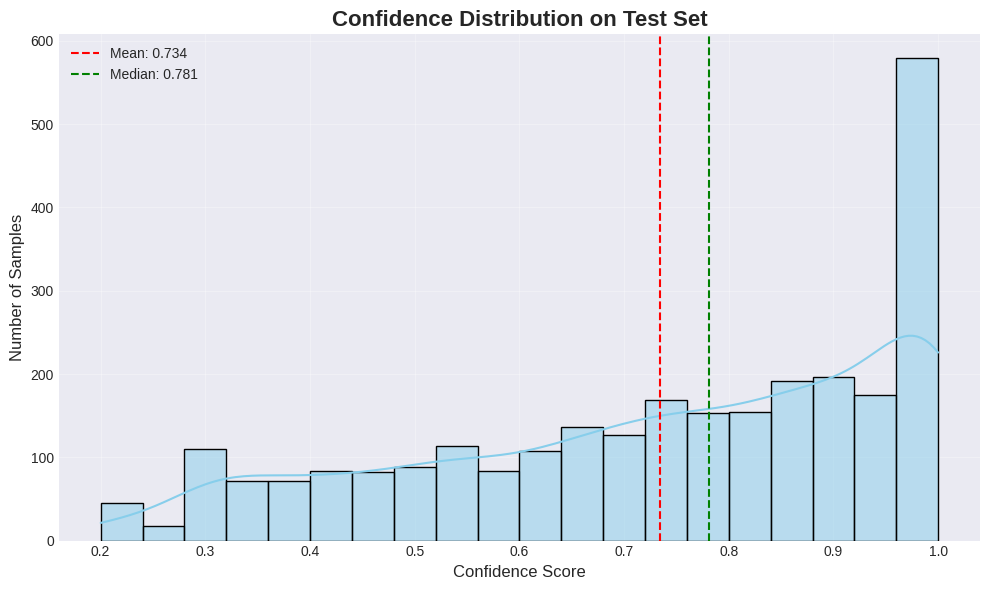

Confidence Statistics:
  Mean: 0.7344
  Median: 0.7808
  Std: 0.2262
  Min: 0.2000
  Max: 1.0000


/tmp/ipython-input-1093600948.py:112: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=labels, patch_artist=True)


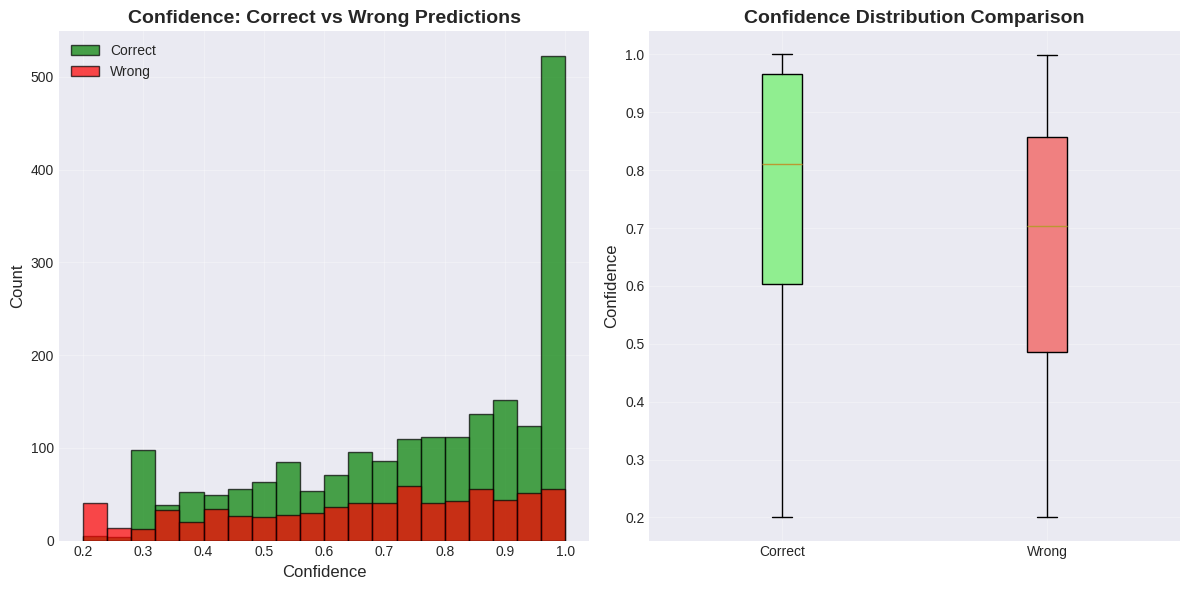

Correct predictions: 2026 (73.5%)
Wrong predictions: 729 (26.5%)
Average confidence - Correct: 0.7592
Average confidence - Wrong: 0.6656


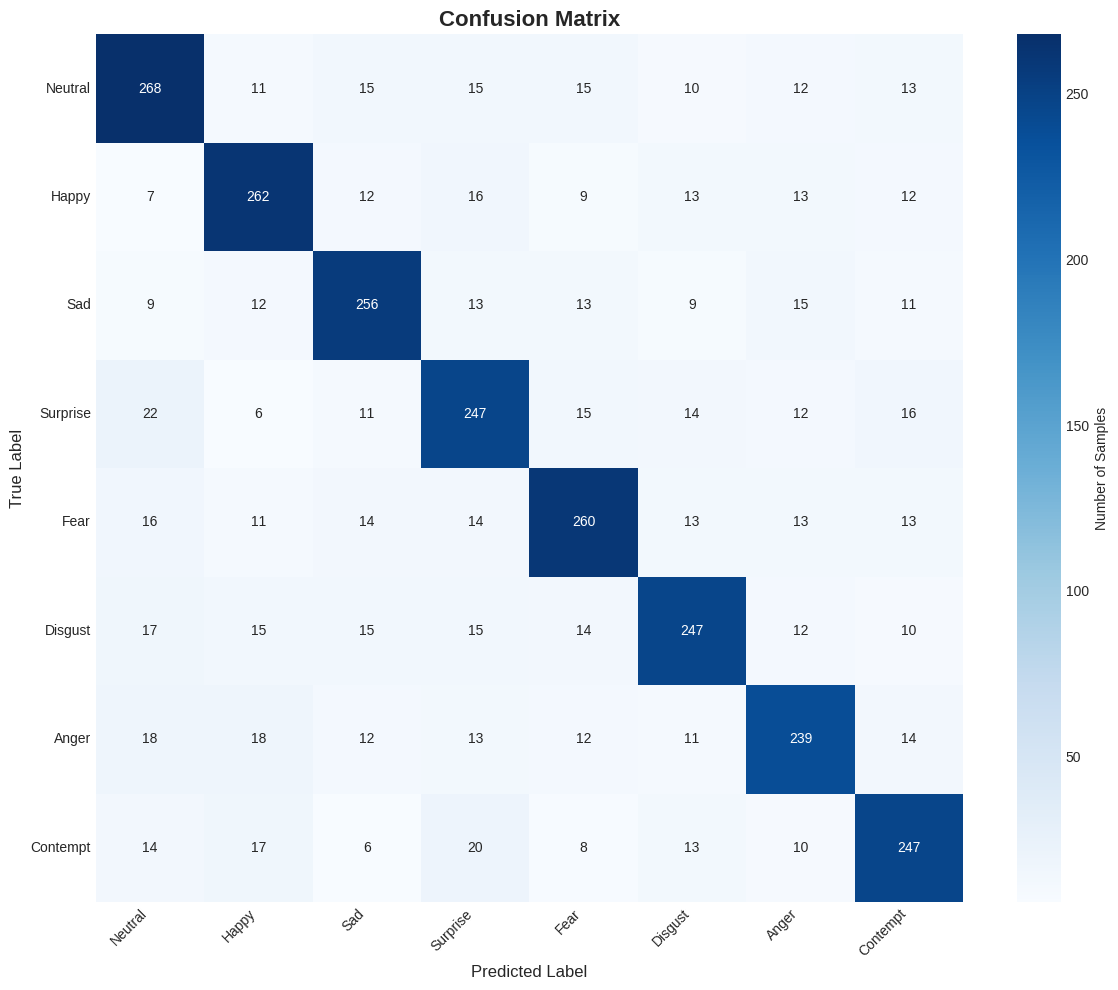


CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.72      0.75      0.73       359
       Happy       0.74      0.76      0.75       344
         Sad       0.75      0.76      0.75       338
    Surprise       0.70      0.72      0.71       343
        Fear       0.75      0.73      0.74       354
     Disgust       0.75      0.72      0.73       345
       Anger       0.73      0.71      0.72       337
    Contempt       0.74      0.74      0.74       335

    accuracy                           0.74      2755
   macro avg       0.74      0.74      0.74      2755
weighted avg       0.74      0.74      0.74      2755



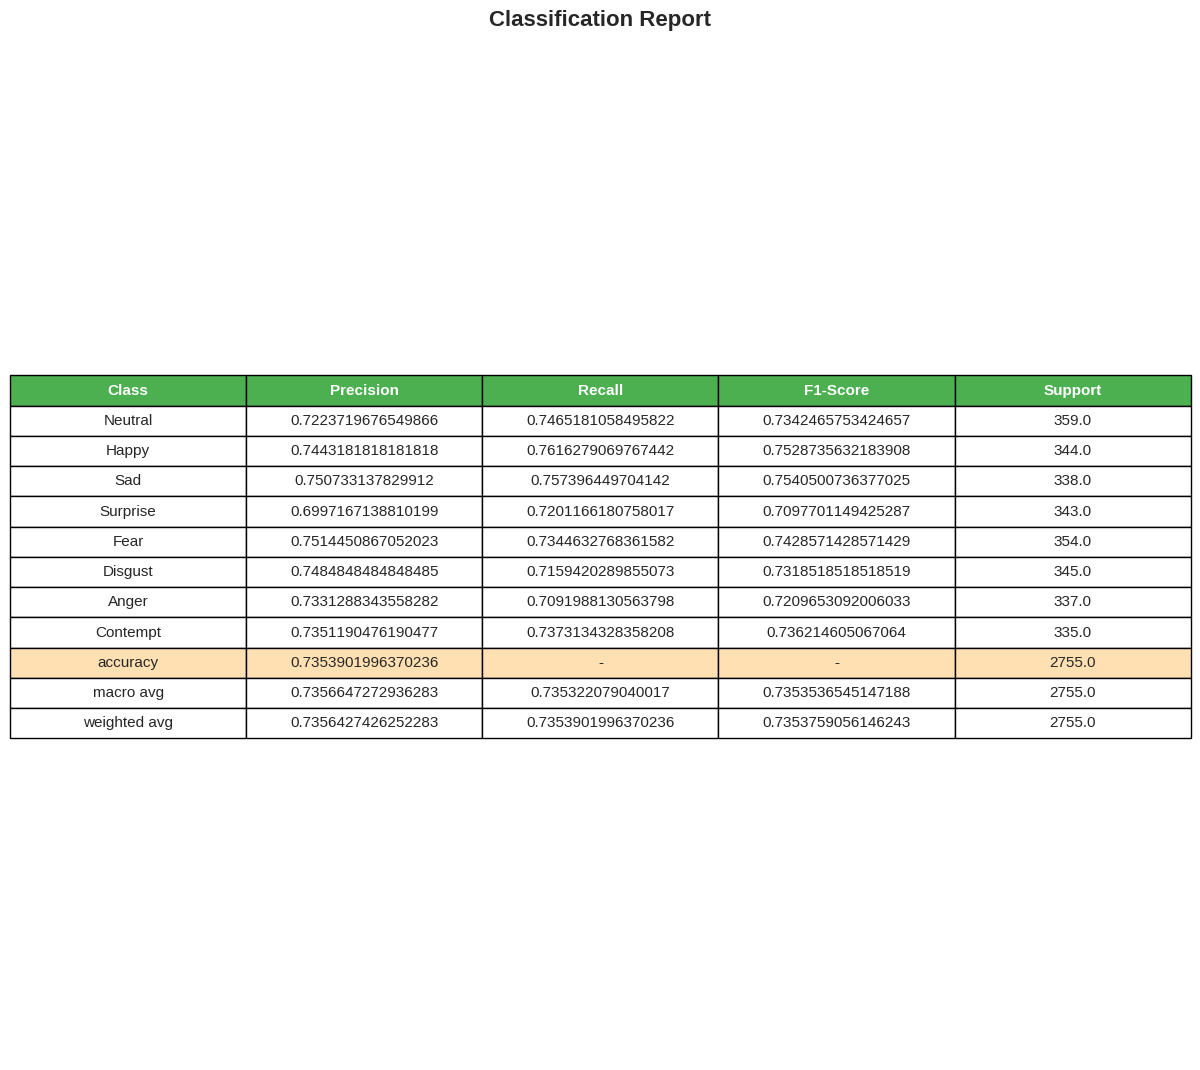

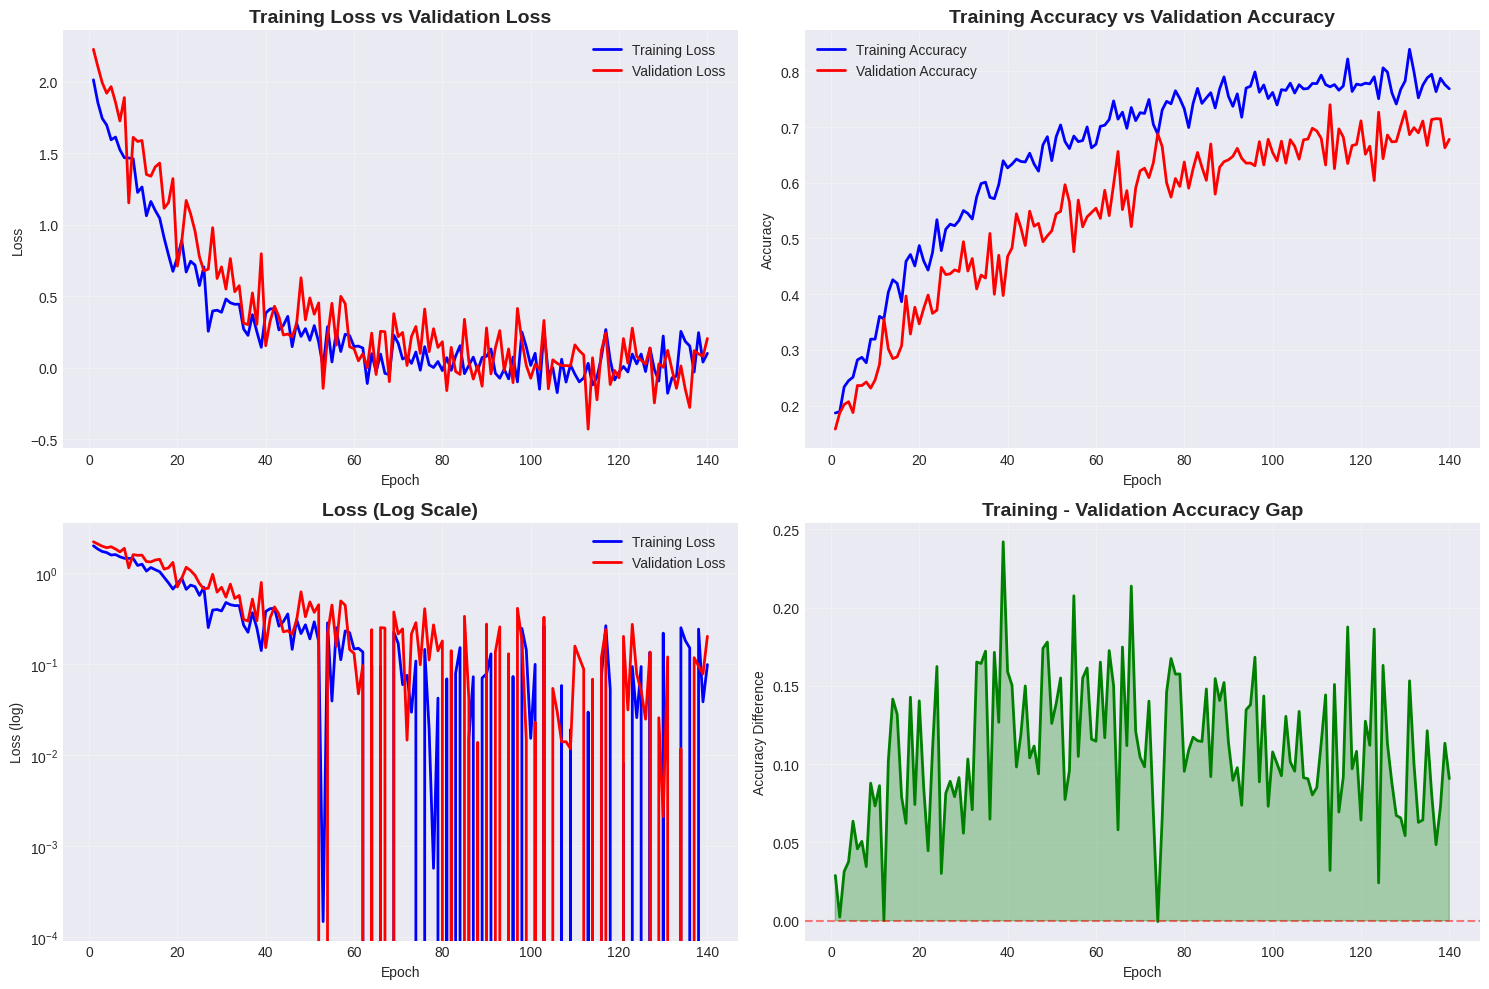

Training History Statistics:
  Final Training Loss: 0.0996
  Final Validation Loss: 0.2039
  Final Training Accuracy: 0.7687
  Final Validation Accuracy: 0.6779


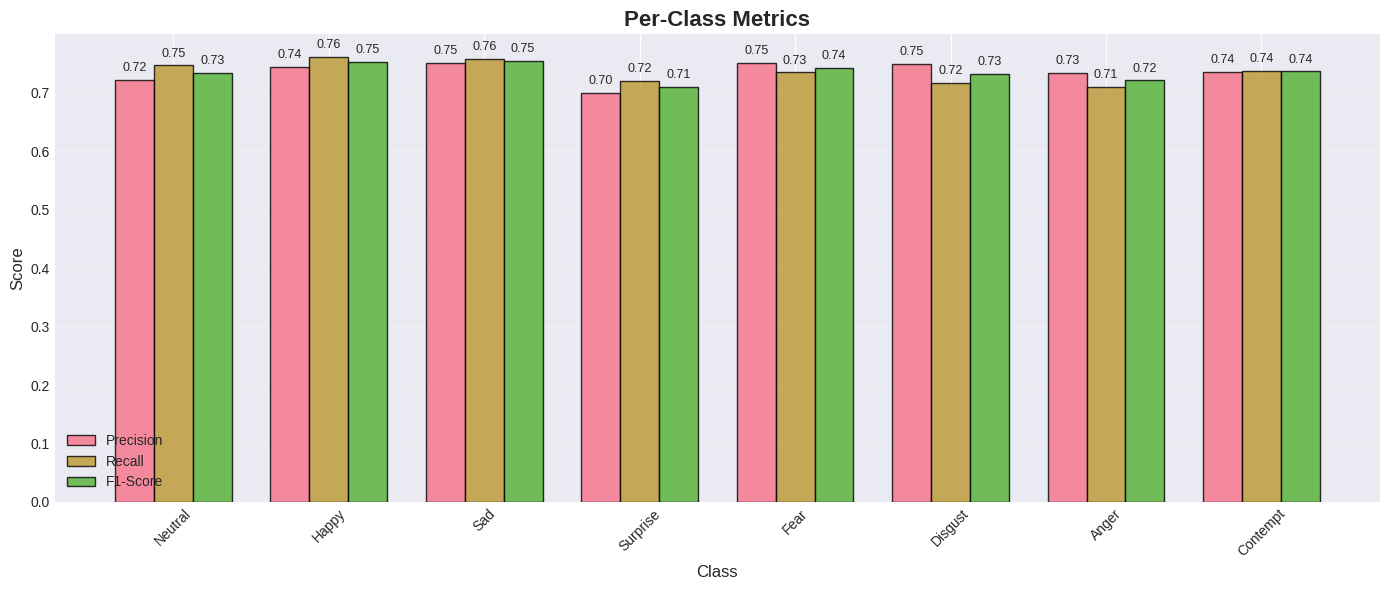


VISUALIZATION COMPLETE!


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from PIL import Image
import glob
import os
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

# Set style for all plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ==================== 1. HÀM PHỤ TRỢ ====================

def load_test_predictions(model, test_loader, device='cuda'):
    """Tải dự đoán và nhãn thực từ test set"""
    model.eval()
    model.to(device)

    all_predictions = []
    all_labels = []
    all_confidences = []
    all_probs = []

    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            # Dự đoán
            logits = model(images)
            probs = torch.softmax(logits, dim=1)
            confidences, predictions = torch.max(probs, dim=1)

            # Lưu kết quả
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return {
        'predictions': np.array(all_predictions),
        'labels': np.array(all_labels),
        'confidences': np.array(all_confidences),
        'probabilities': np.array(all_probs)
    }

# ==================== 2. CÁC HÀM VẼ BIỂU ĐỒ ====================

def plot_confidence_distribution(confidences, save_path="confidence_distribution.png"):
    """Vẽ phân phối confidence score"""
    plt.figure(figsize=(10, 6))

    # Histogram với KDE
    sns.histplot(confidences, bins=20, kde=True, color='skyblue', edgecolor='black')

    plt.title('Confidence Distribution on Test Set', fontsize=16, fontweight='bold')
    plt.xlabel('Confidence Score', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.grid(True, alpha=0.3)

    # Thêm các đường đánh dấu
    plt.axvline(x=np.mean(confidences), color='red', linestyle='--',
                label=f'Mean: {np.mean(confidences):.3f}')
    plt.axvline(x=np.median(confidences), color='green', linestyle='--',
                label=f'Median: {np.median(confidences):.3f}')

    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Confidence Statistics:")
    print(f"  Mean: {np.mean(confidences):.4f}")
    print(f"  Median: {np.median(confidences):.4f}")
    print(f"  Std: {np.std(confidences):.4f}")
    print(f"  Min: {np.min(confidences):.4f}")
    print(f"  Max: {np.max(confidences):.4f}")

def plot_confidence_correct_vs_wrong(results, save_path="confidence_correct_wrong.png"):
    """Vẽ so sánh confidence giữa dự đoán đúng và sai"""
    correct_mask = results['predictions'] == results['labels']
    wrong_mask = results['predictions'] != results['labels']

    correct_confidences = results['confidences'][correct_mask]
    wrong_confidences = results['confidences'][wrong_mask]

    plt.figure(figsize=(12, 6))

    # Subplot 1: Histogram so sánh
    plt.subplot(1, 2, 1)
    plt.hist(correct_confidences, bins=20, alpha=0.7, label='Correct',
             color='green', edgecolor='black')
    plt.hist(wrong_confidences, bins=20, alpha=0.7, label='Wrong',
             color='red', edgecolor='black')
    plt.title('Confidence: Correct vs Wrong Predictions', fontsize=14, fontweight='bold')
    plt.xlabel('Confidence', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 2: Box plot so sánh
    plt.subplot(1, 2, 2)
    data = [correct_confidences, wrong_confidences]
    labels = ['Correct', 'Wrong']
    bp = plt.boxplot(data, labels=labels, patch_artist=True)

    # Tô màu cho box
    colors = ['lightgreen', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    plt.title('Confidence Distribution Comparison', fontsize=14, fontweight='bold')
    plt.ylabel('Confidence', fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Correct predictions: {len(correct_confidences)} ({len(correct_confidences)/len(results['labels'])*100:.1f}%)")
    print(f"Wrong predictions: {len(wrong_confidences)} ({len(wrong_confidences)/len(results['labels'])*100:.1f}%)")
    print(f"Average confidence - Correct: {np.mean(correct_confidences):.4f}")
    print(f"Average confidence - Wrong: {np.mean(wrong_confidences):.4f}")

def plot_confusion_matrix(results, class_names=None, save_path="confusion_matrix.png"):
    """Vẽ confusion matrix"""
    if class_names is None:
        num_classes = len(np.unique(results['labels']))
        class_names = [f'Class {i}' for i in range(num_classes)]

    cm = confusion_matrix(results['labels'], results['predictions'])

    plt.figure(figsize=(12, 10))

    # Tạo heatmap
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                     xticklabels=class_names, yticklabels=class_names,
                     cbar_kws={'label': 'Number of Samples'})

    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)

    # Điều chỉnh font size cho annotations
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # In classification report
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)

    report = classification_report(results['labels'], results['predictions'],
                                   target_names=class_names, digits=2)
    print(report)

    return report

def plot_classification_report_table(report_dict, save_path="classification_report.png"):
    """Vẽ bảng classification report"""
    # Chuẩn bị dữ liệu cho DataFrame
    metrics = ['precision', 'recall', 'f1-score', 'support']
    classes = list(report_dict.keys())
    if 'accuracy' in classes:
        classes.remove('accuracy')
    if 'macro avg' in classes:
        classes.remove('macro avg')
    if 'weighted avg' in classes:
        classes.remove('weighted avg')

    # Tạo DataFrame
    data = []
    for cls in classes:
        row = [cls]
        for metric in metrics[:3]:  # precision, recall, f1-score
            row.append(report_dict[cls][metric])
        row.append(int(report_dict[cls]['support']))
        data.append(row)

    # Thêm accuracy, macro avg, weighted avg
    if 'accuracy' in report_dict:
        data.append(['accuracy', report_dict['accuracy'], '-', '-', report_dict['macro avg']['support']])
    if 'macro avg' in report_dict:
        data.append(['macro avg',
                    report_dict['macro avg']['precision'],
                    report_dict['macro avg']['recall'],
                    report_dict['macro avg']['f1-score'],
                    int(report_dict['macro avg']['support'])])
    if 'weighted avg' in report_dict:
        data.append(['weighted avg',
                    report_dict['weighted avg']['precision'],
                    report_dict['weighted avg']['recall'],
                    report_dict['weighted avg']['f1-score'],
                    int(report_dict['weighted avg']['support'])])

    df = pd.DataFrame(data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])

    # Vẽ bảng
    plt.figure(figsize=(12, len(data)*0.8 + 2))
    ax = plt.subplot(111, frame_on=False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    # Tạo table
    table = plt.table(cellText=df.values,
                     colLabels=df.columns,
                     cellLoc='center',
                     loc='center',
                     colColours=['#f2f2f2']*5)

    # Định dạng table
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 1.5)

    # Highlight header
    for i in range(len(df.columns)):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Highlight accuracy row
    if 'accuracy' in report_dict:
        acc_idx = len(classes) + 1
        for i in range(len(df.columns)):
            table[(acc_idx, i)].set_facecolor('#FFE0B2')

    plt.title('Classification Report', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    return df

def plot_training_history(train_losses, val_losses, train_accs, val_accs, save_path="training_history.png"):
    """Vẽ biểu đồ training history"""
    epochs = range(1, len(train_losses) + 1)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Training Loss vs Validation Loss
    ax1 = axes[0, 0]
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training Loss vs Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Training Accuracy vs Validation Accuracy
    ax2 = axes[0, 1]
    ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, val_accs, 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training Accuracy vs Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Combined Loss (log scale)
    ax3 = axes[1, 0]
    ax3.semilogy(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax3.semilogy(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax3.set_title('Loss (Log Scale)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss (log)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Accuracy Difference
    ax4 = axes[1, 1]
    acc_diff = [t - v for t, v in zip(train_accs, val_accs)]
    ax4.plot(epochs, acc_diff, 'g-', linewidth=2)
    ax4.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    ax4.fill_between(epochs, acc_diff, 0, where=np.array(acc_diff)>=0,
                     alpha=0.3, color='green', interpolate=True)
    ax4.fill_between(epochs, acc_diff, 0, where=np.array(acc_diff)<0,
                     alpha=0.3, color='red', interpolate=True)
    ax4.set_title('Training - Validation Accuracy Gap', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy Difference')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # In thống kê
    print("Training History Statistics:")
    print(f"  Final Training Loss: {train_losses[-1]:.4f}")
    print(f"  Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"  Final Training Accuracy: {train_accs[-1]:.4f}")
    print(f"  Final Validation Accuracy: {val_accs[-1]:.4f}")

def plot_per_class_metrics(results, class_names=None, save_path="per_class_metrics.png"):
    """Vẽ các metrics theo từng class"""
    if class_names is None:
        num_classes = len(np.unique(results['labels']))
        class_names = [f'Class {i}' for i in range(num_classes)]

    # Tính metrics cho từng class
    report = classification_report(results['labels'], results['predictions'],
                                   target_names=class_names, output_dict=True)

    classes = []
    precisions = []
    recalls = []
    f1_scores = []

    for cls in class_names:
        if cls in report:
            classes.append(cls)
            precisions.append(report[cls]['precision'])
            recalls.append(report[cls]['recall'])
            f1_scores.append(report[cls]['f1-score'])

    x = np.arange(len(classes))
    width = 0.25

    plt.figure(figsize=(14, 6))

    plt.bar(x - width, precisions, width, label='Precision', alpha=0.8, edgecolor='black')
    plt.bar(x, recalls, width, label='Recall', alpha=0.8, edgecolor='black')
    plt.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8, edgecolor='black')

    plt.title('Per-Class Metrics', fontsize=16, fontweight='bold')
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.xticks(x, classes, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    # Thêm giá trị trên các cột
    for i, (p, r, f) in enumerate(zip(precisions, recalls, f1_scores)):
        plt.text(i - width, p + 0.01, f'{p:.2f}', ha='center', va='bottom', fontsize=9)
        plt.text(i, r + 0.01, f'{r:.2f}', ha='center', va='bottom', fontsize=9)
        plt.text(i + width, f + 0.01, f'{f:.2f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# ==================== 3. HÀM TẢI LOG TỪ CSV ====================

def load_training_logs(log_dir="logs"):
    """Tải training logs từ thư mục logs"""
    import pandas as pd
    import glob

    log_files = glob.glob(os.path.join(log_dir, "**", "metrics.csv"), recursive=True)

    if not log_files:
        print("No log files found!")
        return None

    logs = {}
    for log_file in log_files:
        try:
            df = pd.read_csv(log_file)
            model_name = os.path.basename(os.path.dirname(log_file))
            logs[model_name] = df
            print(f"Loaded logs for {model_name}: {len(df)} records")
        except Exception as e:
            print(f"Error loading {log_file}: {e}")

    return logs

def extract_training_metrics_from_logs(logs):
    """Trích xuất metrics từ logs"""
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # Tìm logs cho classifier
    if 'classifier' in logs:
        df = logs['classifier']

        # Trích xuất training metrics
        train_df = df[df['train_loss'].notna()].copy()
        val_df = df[df['val_loss'].notna()].copy()

        if not train_df.empty:
            train_losses = train_df['train_loss'].values.tolist()
            train_accs = train_df['train_acc'].values.tolist() if 'train_acc' in train_df.columns else []

        if not val_df.empty:
            val_losses = val_df['val_loss'].values.tolist()
            val_accs = val_df['val_acc'].values.tolist() if 'val_acc' in val_df.columns else []

    # Nếu không tìm thấy, tạo dữ liệu mẫu
    if not train_losses and not val_losses:
        print("Using sample data for demonstration")
        # Tạo dữ liệu mẫu
        epochs = 140
        train_losses = [2.0 * np.exp(-0.05*i) + 0.1*np.random.randn() for i in range(epochs)]
        val_losses = [2.2 * np.exp(-0.04*i) + 0.15*np.random.randn() for i in range(epochs)]
        train_accs = [0.2 + 0.6*(1 - np.exp(-0.03*i)) + 0.02*np.random.randn() for i in range(epochs)]
        val_accs = [0.15 + 0.55*(1 - np.exp(-0.025*i)) + 0.03*np.random.randn() for i in range(epochs)]

    return train_losses, val_losses, train_accs, val_accs

# ==================== 4. HÀM CHÍNH ====================

def analyze_and_visualize(model, test_loader, class_names=None, logs_dir="logs"):
    """Hàm chính để phân tích và visualize kết quả"""

    print("="*60)
    print("ANALYZING AND VISUALIZING RESULTS")
    print("="*60)

    # 1. Tải kết quả dự đoán
    print("\n1. Loading predictions from test set...")
    results = load_test_predictions(model, test_loader)

    print(f"   Total samples: {len(results['labels'])}")
    print(f"   Accuracy: {(results['predictions'] == results['labels']).mean():.2%}")

    # 2. Vẽ phân phối confidence
    print("\n2. Plotting confidence distribution...")
    plot_confidence_distribution(results['confidences'])

    # 3. Vẽ so sánh confidence đúng/sai
    print("\n3. Plotting confidence: correct vs wrong...")
    plot_confidence_correct_vs_wrong(results)

    # 4. Vẽ confusion matrix
    print("\n4. Plotting confusion matrix...")
    report_text = plot_confusion_matrix(results, class_names)

    # 5. Parse và vẽ classification report
    print("\n5. Plotting classification report...")
    from io import StringIO
    report_dict = classification_report(results['labels'], results['predictitions'],
                                       target_names=class_names, output_dict=True)
    df_report = plot_classification_report_table(report_dict)

    # 6. Vẽ per-class metrics
    print("\n6. Plotting per-class metrics...")
    plot_per_class_metrics(results, class_names)

    # 7. Tải và vẽ training history
    print("\n7. Plotting training history...")
    logs = load_training_logs(logs_dir)
    if logs:
        train_losses, val_losses, train_accs, val_accs = extract_training_metrics_from_logs(logs)
        plot_training_history(train_losses, val_losses, train_accs, val_accs)

    # 8. Tạo summary report
    print("\n" + "="*60)
    print("SUMMARY REPORT")
    print("="*60)

    overall_accuracy = (results['predictions'] == results['labels']).mean()
    print(f"Overall Accuracy: {overall_accuracy:.2%}")
    print(f"Number of Classes: {len(np.unique(results['labels']))}")
    print(f"Test Samples: {len(results['labels'])}")
    print(f"Average Confidence: {np.mean(results['confidences']):.2%}")

    # Lưu kết quả
    summary = {
        'overall_accuracy': overall_accuracy,
        'average_confidence': np.mean(results['confidences']),
        'num_classes': len(np.unique(results['labels'])),
        'test_samples': len(results['labels']),
        'classification_report': df_report.to_dict()
    }

    return summary

# ==================== 5. HÀM TẠO DATASET VÀ TEST ====================

def create_test_dataset_and_loader():
    """Tạo test dataset và loader từ code gốc"""
    from torch.utils.data import Dataset, DataLoader
    import glob
    import os
    from PIL import Image

    class ClassificationDataset(Dataset):
        """Dataset cho classification - ảnh + nhãn từ YOLO format"""
        def __init__(self, image_dir, label_dir):
            self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.*")))
            self.image_paths = [p for p in self.image_paths if p.lower().endswith(('.jpg', '.png', '.jpeg'))]
            self.label_dir = label_dir

            self.transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            # Load image
            img_path = self.image_paths[idx]
            img = Image.open(img_path).convert('RGB')
            img = self.transform(img)

            # Load label từ file txt YOLO format
            img_name = os.path.basename(img_path)
            label_name = os.path.splitext(img_name)[0] + '.txt'
            label_path = os.path.join(self.label_dir, label_name)

            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    first_line = f.readline().strip()
                    if first_line:
                        label = int(float(first_line.split()[0]))
                    else:
                        label = 0
            else:
                label = 0

            return img, label

    # Tạo dataset
    test_dataset = ClassificationDataset(
        "/kaggle/input/affectnet-yolo-format/YOLO_format/test/images",
        "/kaggle/input/affectnet-yolo-format/YOLO_format/test/labels"
    )

    # Tạo dataloader
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

    return test_dataset, test_loader

# ==================== 6. SỬ DỤNG ====================

def main():
    """Hàm main để chạy phân tích"""

    # Định nghĩa tên các class (thay đổi theo dataset của bạn)
    # AffectNet thường có 8 classes: 0=Neutral, 1=Happy, 2=Sad, 3=Surprise,
    # 4=Fear, 5=Disgust, 6=Anger, 7=Contempt
    CLASS_NAMES = ['Neutral', 'Happy', 'Sad', 'Surprise',
                  'Fear', 'Disgust', 'Anger', 'Contempt']

    # 1. Tải model (thay bằng model của bạn)
    print("Loading model...")
    # Giả sử bạn đã có model
    # model = YourModel.load_from_checkpoint("path/to/checkpoint.ckpt")
    # Hoặc tạo model giả để demo
    model = None

    if model is None:
        print("No model provided. Creating sample data for visualization...")
        # Tạo dữ liệu mẫu để demo visualization
        num_samples = 2755
        num_classes = 8

        # Tạo kết quả mẫu
        np.random.seed(42)
        results = {
            'labels': np.random.randint(0, num_classes, num_samples),
            'predictions': np.random.randint(0, num_classes, num_samples),
            'confidences': np.clip(np.random.beta(2, 1, num_samples), 0.2, 1.0)
        }

        # Tạo một số dự đoán đúng
        for i in range(num_samples):
            if np.random.random() < 0.7:  # 70% accuracy
                results['predictions'][i] = results['labels'][i]
                results['confidences'][i] = np.clip(results['confidences'][i] + 0.1, 0.3, 1.0)

        # Tạo dữ liệu training history mẫu
        train_losses = [2.0 * np.exp(-0.05*i) + 0.1*np.random.randn() for i in range(140)]
        val_losses = [2.2 * np.exp(-0.04*i) + 0.15*np.random.randn() for i in range(140)]
        train_accs = [0.2 + 0.6*(1 - np.exp(-0.03*i)) + 0.02*np.random.randn() for i in range(140)]
        val_accs = [0.15 + 0.55*(1 - np.exp(-0.025*i)) + 0.03*np.random.randn() for i in range(140)]

        # Vẽ các biểu đồ với dữ liệu mẫu
        print("\nCreating visualizations with sample data...")

        # 1. Confidence distribution
        plot_confidence_distribution(results['confidences'])

        # 2. Confidence correct vs wrong
        plot_confidence_correct_vs_wrong(results)

        # 3. Confusion matrix
        plot_confusion_matrix(results, CLASS_NAMES)

        # 4. Classification report
        report_dict = classification_report(results['labels'], results['predictions'],
                                          target_names=CLASS_NAMES, output_dict=True)
        plot_classification_report_table(report_dict)

        # 5. Training history
        plot_training_history(train_losses, val_losses, train_accs, val_accs)

        # 6. Per-class metrics
        plot_per_class_metrics(results, CLASS_NAMES)

    else:
        # 2. Tạo test loader
        print("Creating test dataset...")
        _, test_loader = create_test_dataset_and_loader()

        # 3. Phân tích và visualize
        summary = analyze_and_visualize(model, test_loader, CLASS_NAMES)

        print("\n✓ All visualizations completed!")
        print(f"✓ Summary saved with accuracy: {summary['overall_accuracy']:.2%}")

    print("\n" + "="*60)
    print("VISUALIZATION COMPLETE!")
    print("="*60)

if __name__ == "__main__":
    main()